# LabPractice 4.4: Forecasting IV

For this practice, you will need the following datasets:
- **SARIMA.xlsx**: dataset containing emissions of SO2 and NO2 particles.

The main package for time series analysis in Python is **statsmodels**.

Further reading:
- [statsmodels](https://www.statsmodels.org/stable/index.html)

In addition, we will be using the following libraries:
- Data management
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)

- Plotting
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)

- Others
    - MLTools
    - [scipy](https://scipy.org/)

In [8]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

---
## 1. Read the dataset

In [4]:
# Import data
#df = pd.read_csv('SARIMA.csv',sep=';')
df = pd.read_csv('C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/datos/ARIMA_2.dat',sep=' ')
df.head()

,y
1,7.852847
2,8.263543
3,8.543455
4,8.733633
5,8.665409


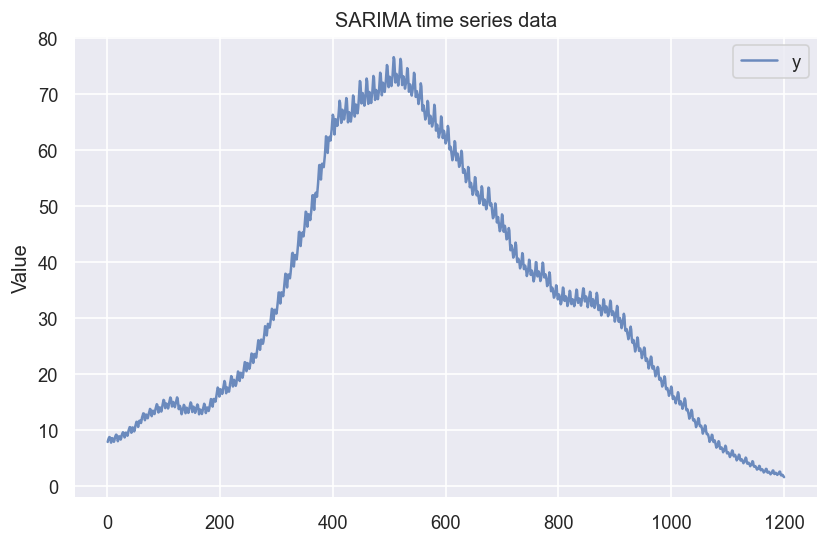

In [5]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='SARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

In [6]:
df_ts = df[['y']] # Maintain data.frame format for column
df_ts

,y
1,7.852847
2,8.263543
3,8.543455
4,8.733633
5,8.665409
...,...
1196,1.941215
1197,1.994511
1198,1.901136
1199,1.724911


---
### Identification process

#### 1. Plot the series and search for possible outliers

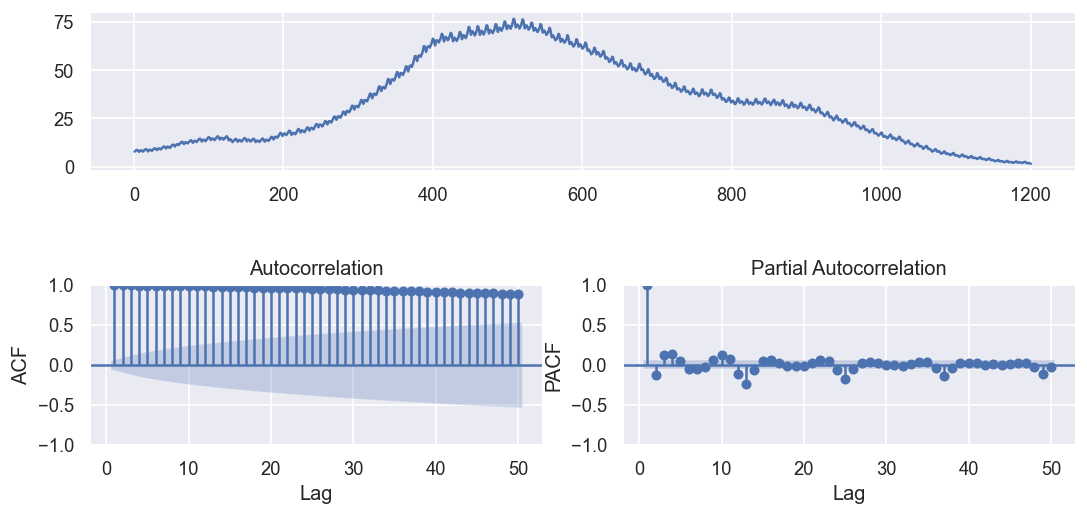

In [9]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts,lags=50)

#### 2. Stabilize the variance (if needed)

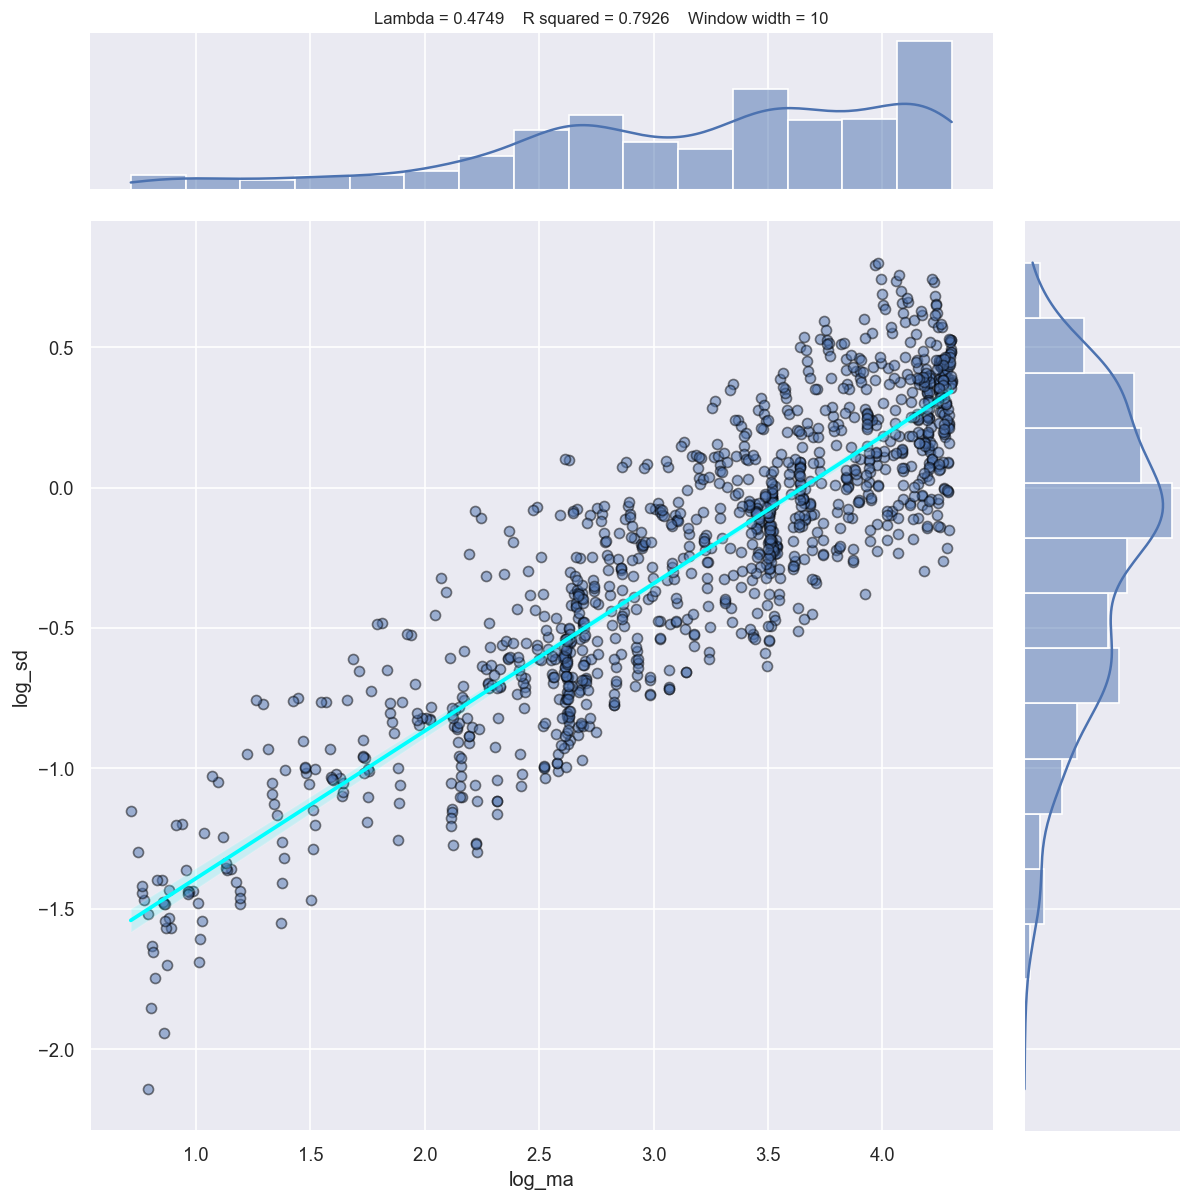

0.4749440513959484

In [ ]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df_ts, window_width=10)

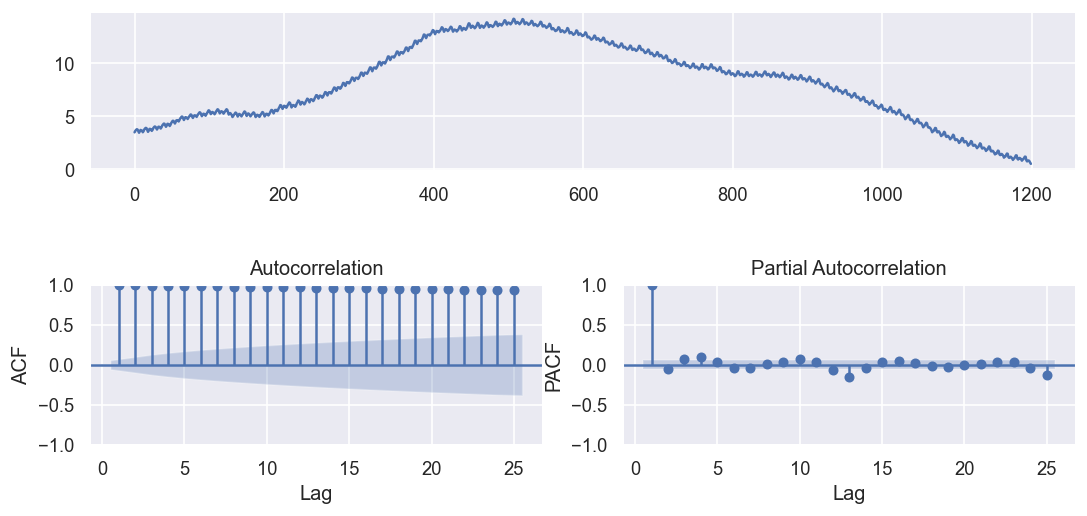

In [ ]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.47 #Select lambda
    z = st.boxcox(df_ts.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
else:
    z = df_ts

# Plot transformed data
FT.ts_display(z)

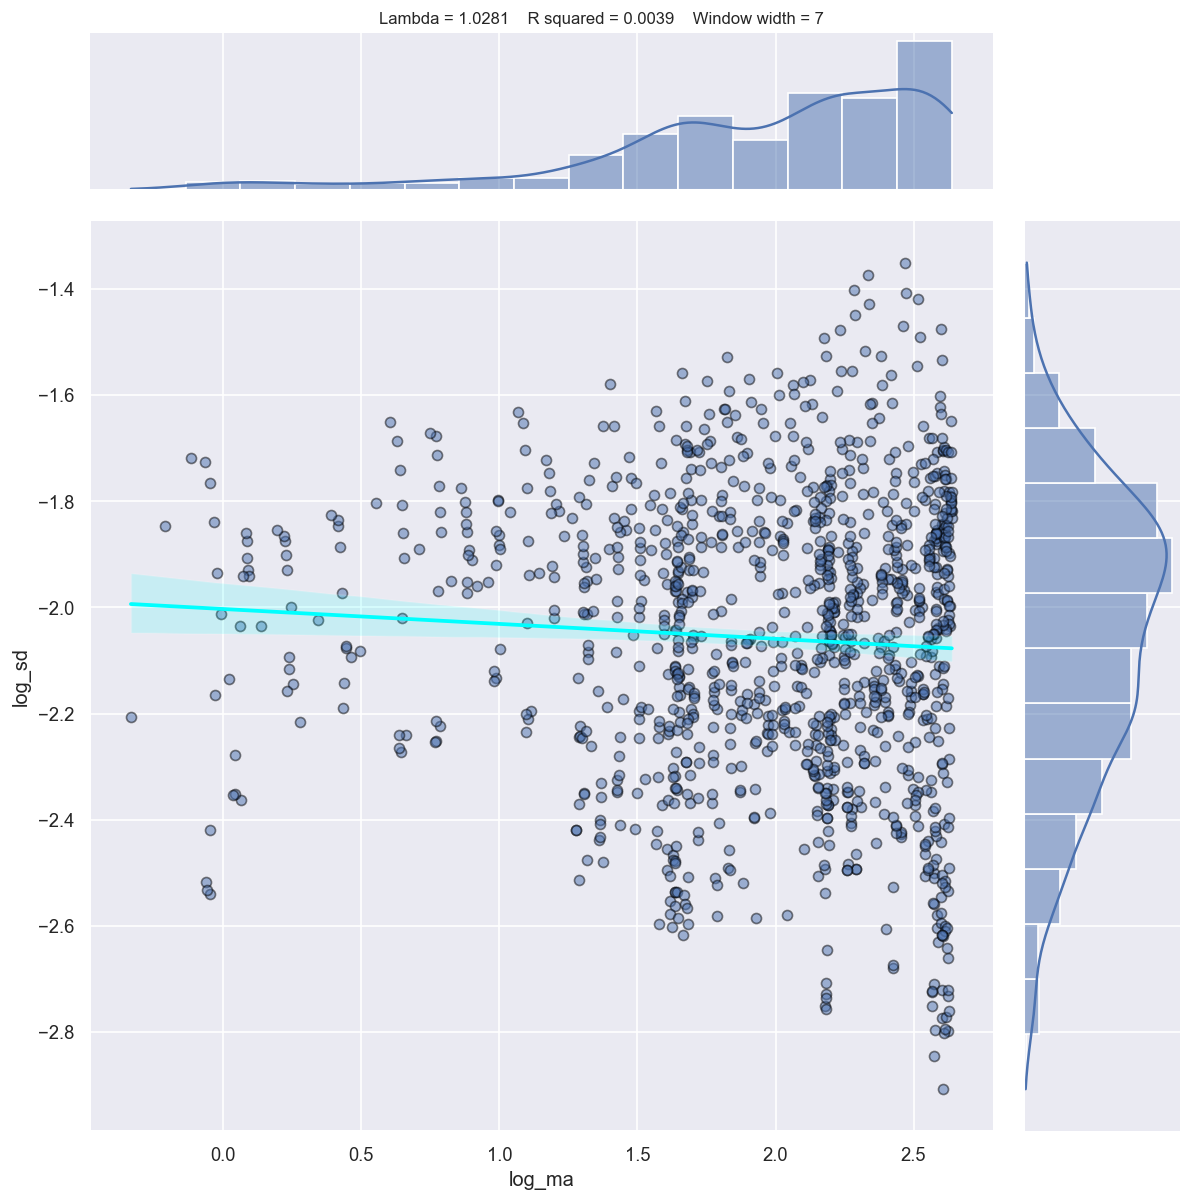

1.0280695735628245

In [ ]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=7)

#### 3. Analyze stationarity 

In [ ]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.932564
p-value: 0.777060
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


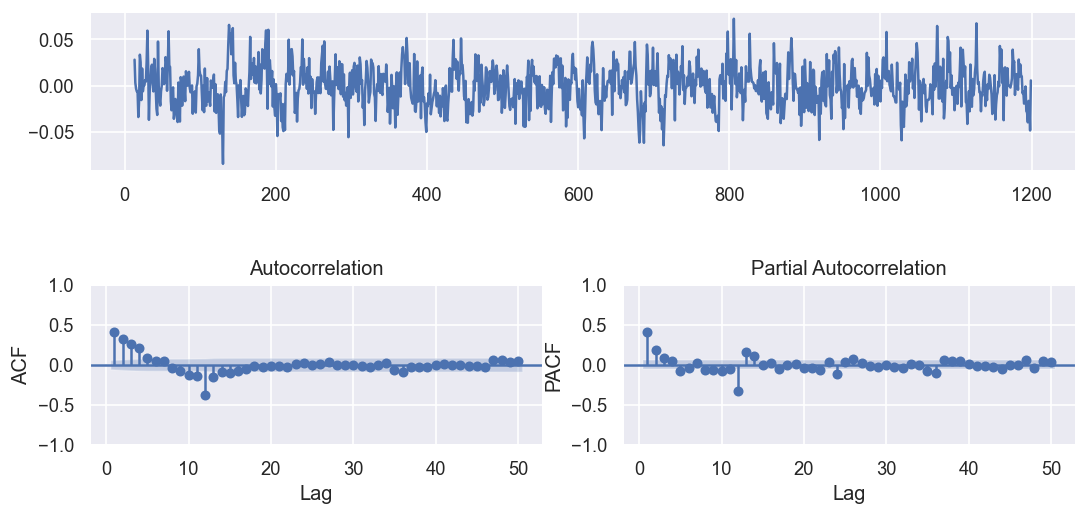

In [ ]:
# Difference of the time series
d = 1
D = 1
S = 12 # Seasonality of 7 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

#### 5. Fit ARIMA model and check significance of the coefficients

In [ ]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(2,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 1200
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                3075.073
Date:                              Tue, 16 Apr 2024   AIC                          -6142.146
Time:                                      14:16:47   BIC                          -6121.873
Sample:                                           0   HQIC                         -6134.501
                                             - 1200                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3421      0.029     11.708      0.000       0.285       0.399
ar.L2          0.19

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  33.954267   0.108889


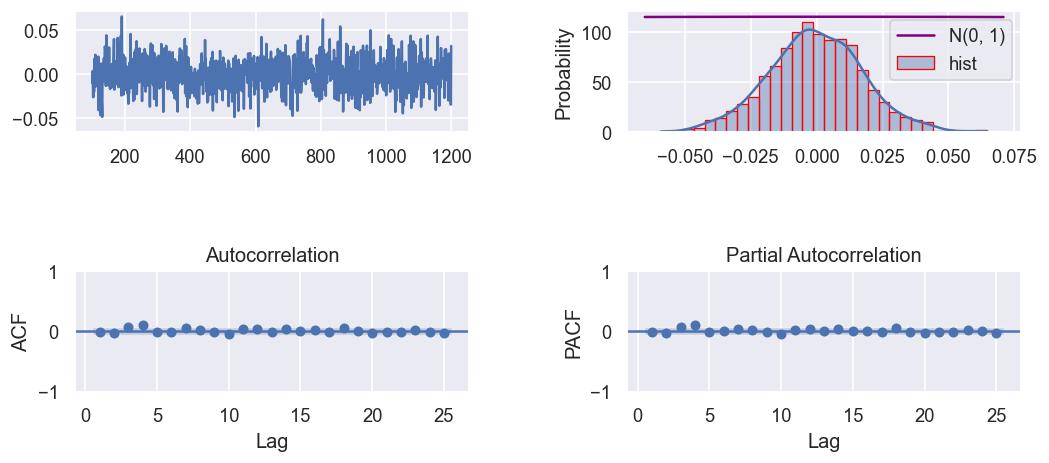

In [ ]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

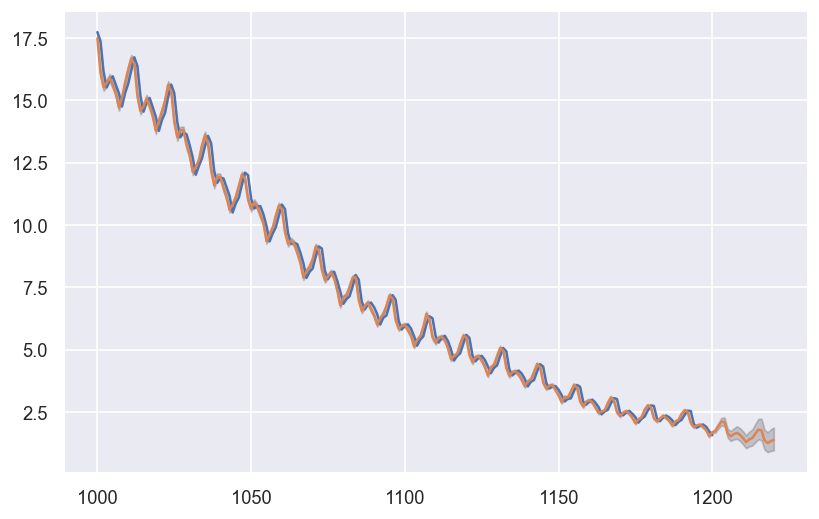

In [ ]:
#Obtain forecasts for in-sample and out-of-sample
start = 1000
horizon = 20
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()

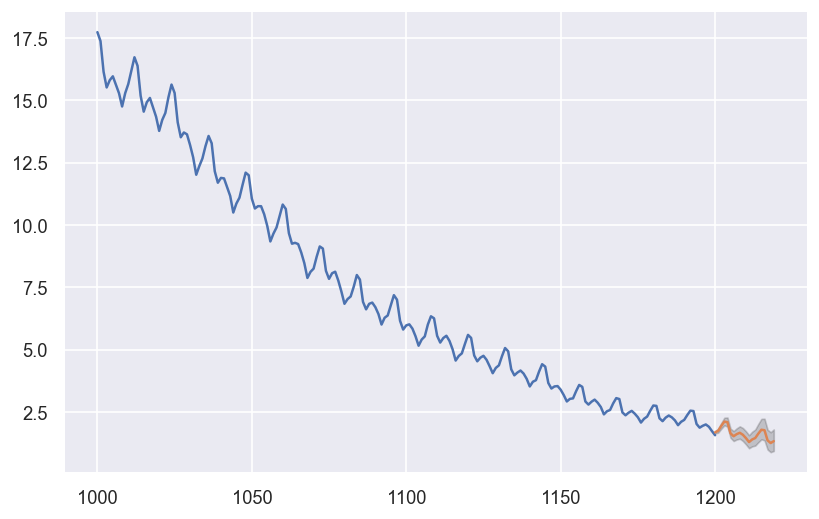

In [ ]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 20
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[1000:])
plt.plot(yhat)
plt.show()